**Data preparation** is one of the essential processes in machine learning projects workflow: with well-prepared input even simple algorithm can achieve great result, and without it --- it’s hard to get something meaningful even using the most sophisticated models (remember concept of "[garbage in — garbage out](https://en.wikipedia.org/wiki/Garbage_in,_garbage_out)").

Usually, specific preparation of data for ML modeling can be considered as part of [ETL](https://en.wikipedia.org/wiki/Extract,_transform,_load) process and consists of following steps:

* **feature engineering**: transformation of raw data into proper features, that can be useful for modeling; sometimes, when original data is complex enough (e. g. text, images) this process is also called *feature extraction, feature preparation*.
* **feature selection**: removing unnecessary features (usually it can help to improve model quality/performance/etc).


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

from sklearn.datasets import make_classification, load_wine, load_breast_cancer, load_diabetes

In [7]:
plt.style.use('seaborn-darkgrid')

In [8]:
def plot_scatter(x, y, auto_scaled=True, title=None, clusters=None):
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, c = clusters, cmap = 'bwr')
    
    if not auto_scaled:
        plt.axis('square')
    
    plt.grid(True)
    plt.title(title)
    
    plt.show()
    
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

# Homework

## Exercise  1 - Scaling (3 points)

Perform standardization for wine dataset (`wine_data`) using only basic python, numpy and pandas (without using `StandardScaler` and sklearn at all). Implementation of function (or class) that can get dataset as input and return standardized dataset as output is preferrable, but not necessary.

Compare you results (output) with `StandardScaler`.

**NOTE:**

1) 1.5 points is for correct wine dataset standardization and another 1.5 points is for implementation of standardization function, that is working in more general case.

2) "General case" doesn't mean, that you need to handle some/all really "specific" cases (datasets with missing/categorial variables, very large dataset, etc). Let's assume that it should work with numeric datasets of reasonable shape: showing the output for one or two randomly generated 10x10 dataset and comparing the results with `StandardScaler` should be enough (or you can be more creative).



In [9]:
def my_scaling(dataset):
    ds_copy = dataset.copy()
    for sr in ds_copy:
        ds_copy[sr] = (ds_copy[sr] - ds_copy[sr].mean())/np.nanstd(ds_copy[sr])
    return ds_copy

In [10]:
size = 10
wine_data_sample = wine_data.sample(n = size, axis = 1).sample(n = size)

scaler = StandardScaler()
wine_data_scaled = scaler.fit_transform(wine_data_sample)
custom_scaling = my_scaling(wine_data_sample)

assert np.allclose(custom_scaling.to_numpy(), wine_data_scaled), "Custom scaling is not accurate enough"
custom_scaling

,od280/od315_of_diluted_wines,alcalinity_of_ash,flavanoids,ash,nonflavanoid_phenols,magnesium,alcohol,malic_acid,hue,total_phenols
43,-0.068743,-0.690392,-0.020949,-0.572053,-0.282901,-0.159233,1.099289,2.410602,-1.206045,0.477712
127,-1.396185,1.892707,-0.450965,0.696300,1.880463,-0.763218,-1.011928,0.199589,-0.301511,-0.972486
23,1.424631,-0.619944,-0.307626,0.023296,-0.782139,-0.598495,0.531444,-0.433837,0.422116,0.022748
121,1.566857,1.892707,2.680428,1.861115,0.965193,0.719292,-1.346810,0.103977,-0.542720,2.013217
69,0.097188,-0.854771,-1.509463,-1.969831,-1.780615,2.476340,-0.400403,-0.923845,1.567859,-1.768674
84,0.120892,-0.572978,-0.484043,0.178605,-1.114965,-0.653402,-0.939127,-1.282388,-1.386952,-0.773439
65,-1.728046,-0.549496,0.001103,0.126835,0.133130,-0.433771,-0.167441,-0.899942,1.025139,-0.147863
32,-0.376899,-0.760840,0.045207,-0.390860,0.549162,-0.104325,1.739934,-0.158954,1.266348,-0.147863
125,0.594979,0.131503,0.001103,-0.882671,0.133130,-1.147572,-0.604245,0.235443,-0.964836,0.363971
4,-0.234673,0.131503,0.045207,0.929263,0.299543,0.664384,1.099289,0.749354,0.120605,0.932677


## Exercise  2 - Visualization (4 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let’s generate some toy example of unnormalized data and visualize the importance of this process once more:

In [11]:
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
data 

array([[  8.00087352,  -2.68499743],
       [ 13.24227148,  -1.22211938],
       [  0.80244532,   0.09745221],
       ...,
       [-10.93555316,   5.12763258],
       [-13.49646455,   3.45753951],
       [ -6.92742386,   5.45219105]])

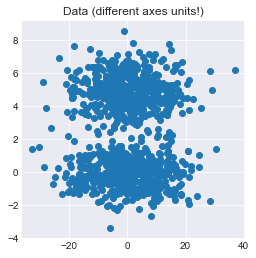

In [12]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True, title='Data (different axes units!)')

**NOTE:** on the plot above axes are scaled differently and we can clearly see two potential *classes/clusters*. In fact `matplotlib` performed `autoscaling` (which is basically can be considered as `MinMaxScaling` of original data) just for better visualization purposes.

Let's turn this feature off and visualize the original data on the plot with equally scaled axes:

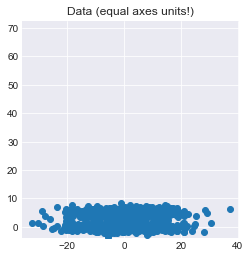

In [13]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Data (equal axes units!)')

This picture is clearly less interpretable, but much closer to "how distance-based algorithm see the original data": separability of data is hardly noticable only because the variation (std) of x-feature is much bigger in absolute numbers.

Perform `StandardScaling` and `MinMaxScaling` of original data; visualize results for each case (**use `plot_scatter` with `auto_scaled=False`**):

### MinMaxScaling (1 point)

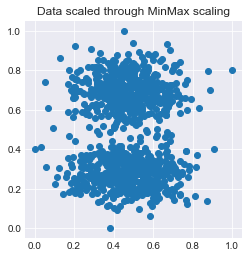

In [14]:
scaler = MinMaxScaler()
min_max = scaler.fit_transform(data)
plot_scatter(min_max[:, 0], min_max[:, 1], auto_scaled=False , title='Data scaled through MinMax scaling')

### StandardScaler (1 point)

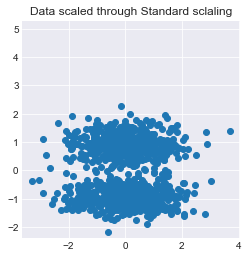

In [15]:
scaler = StandardScaler()
standard = scaler.fit_transform(data)
plot_scatter(standard[:, 0], standard[:, 1], auto_scaled=False , title='Data scaled through Standard sclaling')

### (Bonus) K-means (2 points)

Illustrate the impact of scaling on basic distance-based clustering algorithm [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) using `data` generated above.

**NOTE:** basically, you don't need understanding K-means algorithm here, you just need to:

1) run algorithm (with k=2, k - number of clusters/classes) on unscaled data    
2) run algorithm (with k=2) on scaled data    
3) plot results: highlight different clusters using different colors.

You can use this [question](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) as a hint, but I recommend you to plot results using `plot_scatter` with `equal_scaled=True`: it might help you to intuitively understand the reasons of such scaling impact.


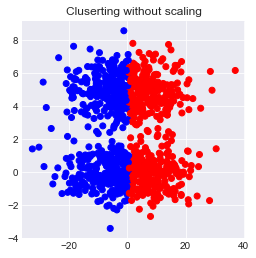

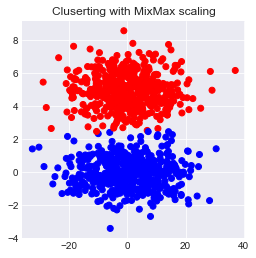

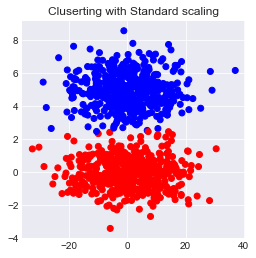

In [16]:
km = KMeans(2)
cl_no_scaling = km.fit_predict(data)
cl_mix_max_scaling = km.fit_predict(min_max)
cl_standard_scaling = km.fit_predict(standard)

plot_scatter(data[:, 0], data[:, 1], auto_scaled=True , title='Cluserting without scaling', clusters=cl_no_scaling)
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True , title='Cluserting with MixMax scaling', clusters=cl_mix_max_scaling)
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True , title='Cluserting with Standard scaling', clusters=cl_standard_scaling)


## Exercise  3 - Preprocessing Pipeline (3 points)

In [17]:
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(wine_data, wine_labels, 
                                                                            test_size=0.4, random_state=42)


Train model (for example, `LogisticRegression(solver='liblinear', penalty='l1')` on raw `wine_train` data; then train same model after data scaling; then add feature selection (and train model again on scaled data).

Measure `accuracy` of all 3 approaches on `wine_val` dataset. Describe and explain results.

In [18]:
selection_model = RandomForestClassifier(random_state=42)

main_model = LogisticRegression(solver='liblinear', penalty='l1')
pipe_baseline = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', penalty='l1'))
pipe_selection = make_pipeline(StandardScaler(), SelectFromModel(selection_model), LogisticRegression(solver='liblinear', penalty='l1')) 

pipe_baseline.fit(wine_train, wine_labels_train)
pipe_selection.fit(wine_train, wine_labels_train)
main_model.fit(wine_train, wine_labels_train)


print (f"{'Accurance of the simple model:':<50}{main_model.score(wine_val, wine_labels_val)}")
print (f"{'Accurance of the model with scaling:':<50}{pipe_baseline.score(wine_val, wine_labels_val)}")
print (f"{'Accurance of the model with feature selection:':<50}{pipe_selection.score(wine_val, wine_labels_val)}")

Accurance of the simple model:                    0.9444444444444444
Accurance of the model with scaling:              0.9861111111111112
Accurance of the model with feature selection:    1.0


As we can see the results are diffirent. The accurance of the model with feature scaling is more than the accurance of the simple model. The model with feature selection gives the better result than the model with feature scaling. It proves that `LogisticRegression`is sensible to feature scale. But it is not so simple with the model with feature selection. You can try to play with the data splitting and the result will be slight diffirent. We can make the conlusion that the feature scaling improves the quality of a model, but you have to be care using the feature selection sometimes it can gets worse your model.

# Materials & References

1. General article about feature engineering and selection (main reference):
https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic06_features_regression/topic6_feature_engineering_feature_selection.ipynb


2. Feature engineering/preprocessing, using scikit-learn API (great code examples, but really brief explanation):    
https://scikit-learn.org/stable/modules/preprocessing


3. Feature scaling/normalization:     
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35


4. Log Transform/power transform:    
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9


6. Missing values preprocessing using scikit-learn API (great code examples, great explanation):    
https://scikit-learn.org/stable/modules/impute.html


7. Feature selection scikit-learn API (great code examples, great explanation):   
https://scikit-learn.org/stable/modules/feature_selection.html


8. Melbourne housing dataset source:    
https://www.kaggle.com/anthonypino/melbourne-housing-market